In [1]:
import torch
import os
import subprocess

repo_root = subprocess.check_output(["git", "rev-parse", "--show-toplevel"]).decode().strip()
os.chdir(repo_root)

print("cwd =", os.getcwd())

from solvers.torch_eit_fem_solver import EIT
from solvers.torch_eit_fem_solver.fem import Mesh, V_h, dtn_map
from solvers.torch_eit_fem_solver.utils import dtn_from_sigma
from torchdiffeq import odeint
import matplotlib.pyplot as plt
import cmocean as cmo
from scipy import io as sio
from tqdm import tqdm
from models.unet import Unet
from collections import OrderedDict
import numpy as np

device = 'cuda:1' 

dataset = torch.load('data/eit-circles-dtn-default-128.pt', map_location='cpu')

data_root = 'mesh-data'
mesh_file = 'mesh_128_h05.mat'
mat_fname = os.path.join(data_root, mesh_file)
mat_contents = sio.loadmat(mat_fname)

p = torch.tensor(mat_contents['p'], dtype=torch.float64).to(device)
t = torch.tensor(mat_contents['t']-1, dtype=torch.long).to(device)
vol_idx = torch.tensor(mat_contents['vol_idx'].reshape((-1,))-1, dtype=torch.long).to(device)
bdy_idx = torch.tensor(mat_contents['bdy_idx'].reshape((-1,))-1, dtype=torch.long).to(device)

mesh = Mesh(p, t, bdy_idx, vol_idx)
v_h = V_h(mesh)

dtn_background = dtn_from_sigma(sigma_vec=torch.ones(128, 128), v_h=v_h, mesh=mesh, img_size=128, device=device).cpu()

train_X = dataset['train']['dtn_map'].float()
# train_X /= dtn_background
train_Y = dataset['train']['media'].float()

train_X_min = train_X.min()
train_X_max = train_X.max()
train_Y_min = train_Y.min()
train_Y_max = train_Y.max()

cwd = /home/johnma/flow-inverse


In [2]:
from models.unet import UnetNoTime
model = UnetNoTime(ch=32).to(device)
checkpoint = torch.load("saved_runs/circles-eit-inverse-unet/checkpoints/ckp_31500.tar", map_location=device)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

UnetNoTime(
  (input_proj): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResBlockNoTime(
        (skip_connection): Identity()
        (block1): Sequential(
          (0): GroupNorm(32, 32, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Identity()
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (block2): Sequential(
          (0): GroupNorm(32, 32, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.1, inplace=False)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (2): Downsample(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
    )
    (1-2): 2 x ModuleList(
      (0-1): 2 x ResBlockNoTime(
        (skip_connection): Identity()
        (block1): Sequential(
          (0): GroupNorm(32, 64, eps=1e-05, affine=True)
          

Relative L2 Error Statistics:
Mean: 0.4499
Std:  0.0899
Min:  0.1780
Max:  0.6799
Median: 0.4578


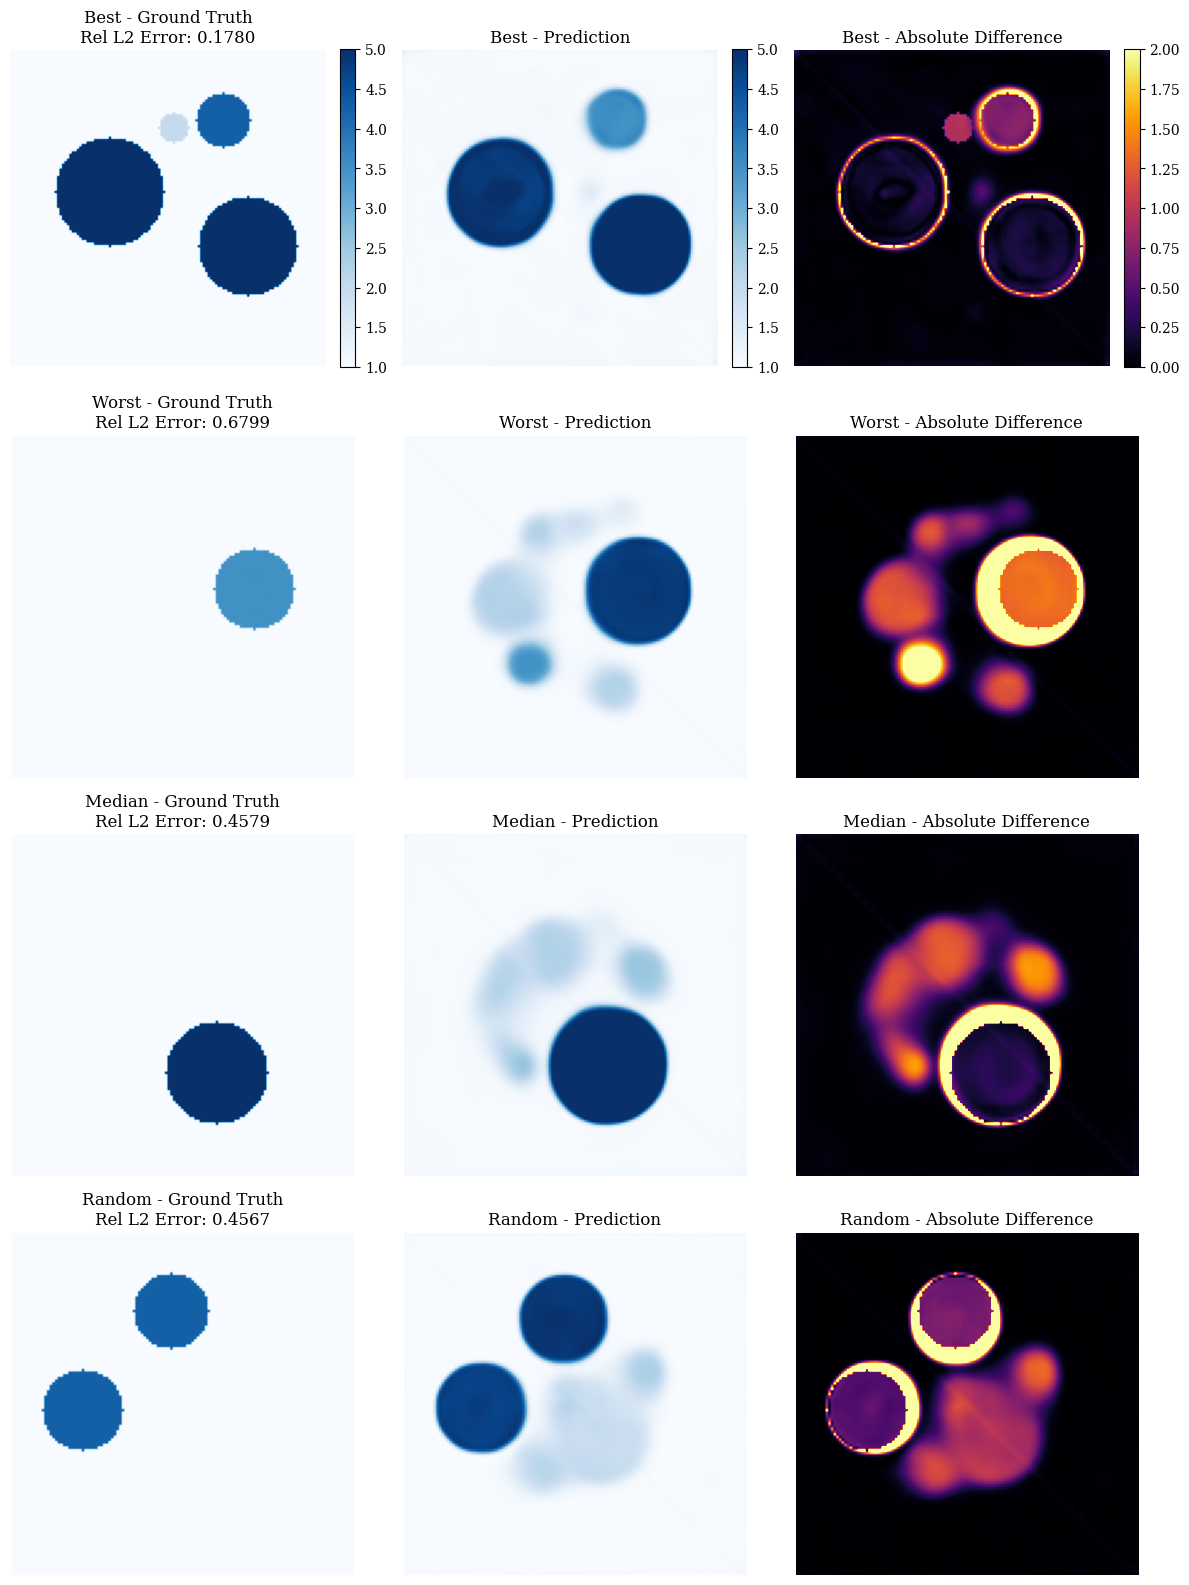

In [3]:
# Evaluation on test data
model.eval()
with torch.no_grad():
    # Make sure we use the correct test set from the refined dataset
    test_X_eval = dataset['test']['dtn_map'].detach().clone().float()
    # test_X_eval /= dtn_background
    test_X_eval = 2.0 * (test_X_eval - train_X_min) / (train_X_max - train_X_min + 1e-12) - 1.0
    test_X_eval = test_X_eval.unsqueeze(1).to(device)
    
    # Run inference
    predictions = model(test_X_eval).squeeze(1)
    
    # Denormalize predictions and ground truth
    pred_denorm = 0.5 * (predictions + 1.0) * (train_Y_max - train_Y_min + 1e-12) + train_Y_min
    gt_denorm = dataset['test']['media'].float().to(device)

    rel_l2_errors = []
    for i in range(len(pred_denorm)):
        pred = pred_denorm[i].cpu()
        gt = gt_denorm[i].cpu()
        
        error = torch.norm(pred - gt, 2) / torch.norm(gt, 2)
        rel_l2_errors.append(error.item())
    
    rel_l2_errors = np.array(rel_l2_errors)
    
    # Print statistics
    print(f"Relative L2 Error Statistics:")
    print(f"Mean: {rel_l2_errors.mean():.4f}")
    print(f"Std:  {rel_l2_errors.std():.4f}")
    print(f"Min:  {rel_l2_errors.min():.4f}")
    print(f"Max:  {rel_l2_errors.max():.4f}")
    print(f"Median: {np.median(rel_l2_errors):.4f}")

    
    plt.rcParams["font.family"] = "DejaVu Serif"
    title_font = {"family": "DejaVu Serif", "weight": "bold", "size": 12}

    
    # Find indices for best, worst, median cases
    best_idx = np.argmin(rel_l2_errors)
    worst_idx = np.argmax(rel_l2_errors)
    median_idx = np.argsort(rel_l2_errors)[len(rel_l2_errors) // 2]
    random_idx = np.random.randint(len(rel_l2_errors))
    
    indices_to_plot = [best_idx, worst_idx, median_idx, random_idx]
    titles = ['Best', 'Worst', 'Median', 'Random']
    
    # Create plots
    fig, axes = plt.subplots(4, 3, figsize=(12, 16))
    
    for i, (idx, title) in enumerate(zip(indices_to_plot, titles)):
        pred = pred_denorm[idx].cpu().numpy()
        gt = gt_denorm[idx].cpu().numpy()
        error = rel_l2_errors[idx]
        
        # Ground truth
        im1 = axes[i, 0].imshow(gt, cmap='Blues', vmin=1, vmax=5)
        axes[i, 0].set_title(f'{title} - Ground Truth\nRel L2 Error: {error:.4f}')
        axes[i, 0].axis('off')
        
        # Prediction
        im2 = axes[i, 1].imshow(pred, cmap='Blues', vmin=1, vmax=5)
        axes[i, 1].set_title(f'{title} - Prediction')
        axes[i, 1].axis('off')
        
        # Difference
        diff = np.abs(pred - gt)
        im3 = axes[i, 2].imshow(diff, cmap='inferno', vmin=0, vmax=2)
        axes[i, 2].set_title(f'{title} - Absolute Difference')
        axes[i, 2].axis('off')
        
        # Add colorbars
        if i == 0:
            fig.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)
            fig.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.04)
            fig.colorbar(im3, ax=axes[0, 2], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

In [36]:
import gc

def evaluate_with_noise(delta):
    with torch.no_grad():
        # 1. Load raw DtN maps
        raw_test_X = dataset['test']['dtn_map'].detach().clone().float()
        
        # 2. Add multiplicative noise PRE-TRANSFORM (before background division)
        # y = (1 + delta * Z) * x, where Z ~ N(0, 1)
        noise_z = torch.randn_like(raw_test_X)
        noisy_test_X = (1 + delta * noise_z) * raw_test_X
        
        # 3. Apply background transformation
        noisy_test_X /= dtn_background
        
        # 4. Normalize using training statistics
        noisy_test_X = 2.0 * (noisy_test_X - train_X_min) / (train_X_max - train_X_min + 1e-12) - 1.0
        noisy_test_X = noisy_test_X.unsqueeze(1).to(device)
        
        # 5. Inference
        predictions = model(noisy_test_X).squeeze(1)
        
        # 6. Denormalize
        pred_denorm = 0.5 * (predictions + 1.0) * (train_Y_max - train_Y_min + 1e-12) + train_Y_min
        test_media_gt = dataset['test']['media'].float().cpu()

        # Calculate Errors
        rel_l2_errors = []
        for i in range(len(pred_denorm)):
            p_i = pred_denorm[i].cpu()
            g_i = test_media_gt[i]
            error = torch.norm(p_i - g_i, 2) / torch.norm(g_i, 2)
            rel_l2_errors.append(error.item())
        
        rel_l2_errors = np.array(rel_l2_errors)
        print(f"Mean Rel L2 Error: {rel_l2_errors.mean():.4f}")
        
        # Find indices for best, worst, median cases
        best_idx = np.argmin(rel_l2_errors)
        worst_idx = np.argmax(rel_l2_errors)
        median_idx = np.argsort(rel_l2_errors)[len(rel_l2_errors) // 2]
        random_idx = np.random.randint(len(rel_l2_errors))
        
        indices_to_viz = [best_idx, worst_idx, median_idx, random_idx]
        viz_titles = ['Best', 'Worst', 'Median', 'Random']

        plt.rcParams["font.family"] = "DejaVu Serif"
        title_font = {"family": "DejaVu Serif", "weight": "bold", "size": 12}

        # 7. Plotting (GT, Pred, Diff)
        fig, axes = plt.subplots(len(indices_to_viz), 3, figsize=(12, 4 * len(indices_to_viz)))
        fig.suptitle(f"Predictions with Noise $\delta = {delta}$ (Mean Error: {rel_l2_errors.mean():.4f})", fontsize=16)
        
        for i, idx in enumerate(indices_to_viz):
            gt_plot = test_media_gt[idx].cpu().numpy()
            pred_plot = pred_denorm[idx].cpu().numpy()
            diff_plot = np.abs(pred_plot - gt_plot)
            
            # Ground Truth
            im1 = axes[i, 0].imshow(gt_plot, cmap='Blues', vmin=1, vmax=5)
            axes[i, 0].set_title(f"{viz_titles[i]} - GT\nErr: {rel_l2_errors[idx]:.4f}")
            axes[i, 0].axis('off')
            
            # Prediction
            im2 = axes[i, 1].imshow(pred_plot, cmap='Blues', vmin=1, vmax=5)
            axes[i, 1].set_title(f"Prediction")
            axes[i, 1].axis('off')
            
            # Difference
            im3 = axes[i, 2].imshow(diff_plot, cmap='inferno', vmin=0, vmax=2)
            axes[i, 2].set_title(f"Abs Difference")
            axes[i, 2].axis('off')
            
            if i == 0:
                fig.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)
                fig.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.04)
                fig.colorbar(im3, ax=axes[0, 2], fraction=0.046, pad=0.04)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        
        # 8. Memory Cleanup
        del noisy_test_X
        del predictions
        del pred_denorm
        gc.collect()
        torch.cuda.empty_cache()

Mean Rel L2 Error: 0.4559


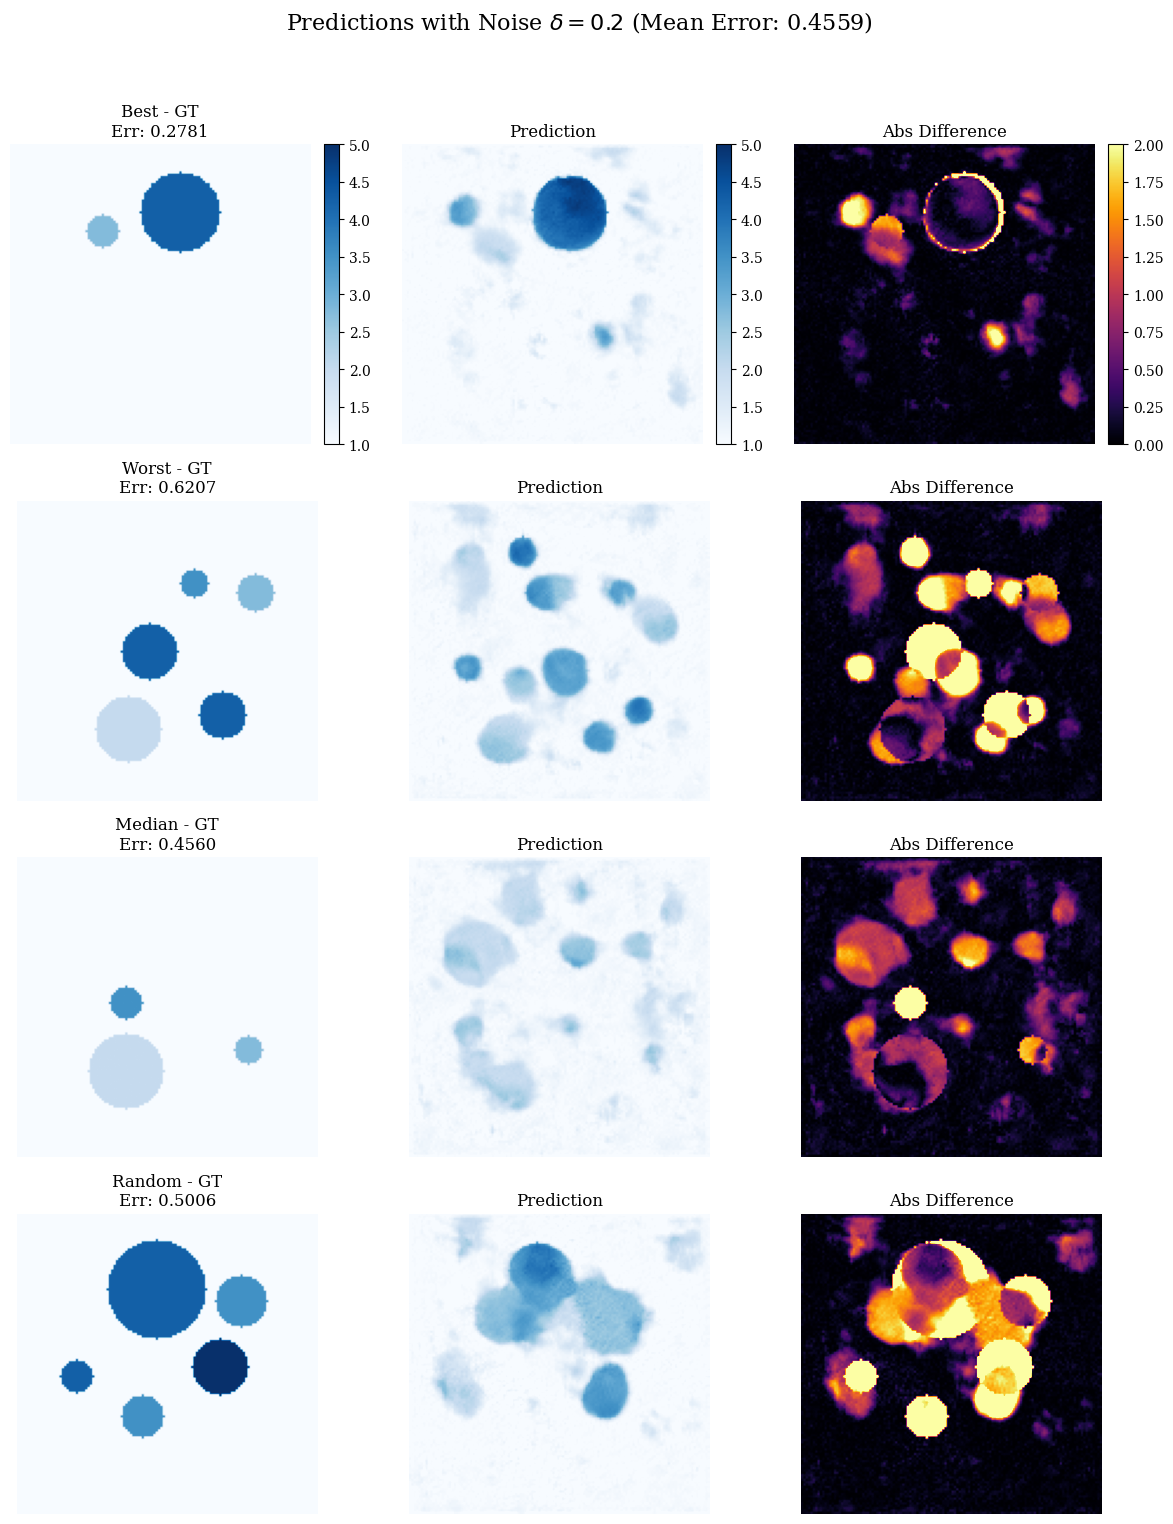

In [38]:
evaluate_with_noise(0.2)